# The Xylo™ IMU preprocessing interface
Xylo™ IMU contains a set of preprocessing blocks designed for encoding IMU data as events for inference using the SNN core on Xylo.

In [2]:
# - Data processing
import numpy as np

# - Plotting and config
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [9.6, 3.6]
plt.rcParams["figure.dpi"] = 1200
plt.rcParams["font.size"] = 12

# - Import modules
from rockpool.devices.xylo.imu.imuif_submod import Quantizer
from rockpool.devices.xylo.imu import IMUIFSim
from samna.xyloImu.configuration import InputInterfaceConfig
from rockpool.timeseries import TSEvent, TSContinuous

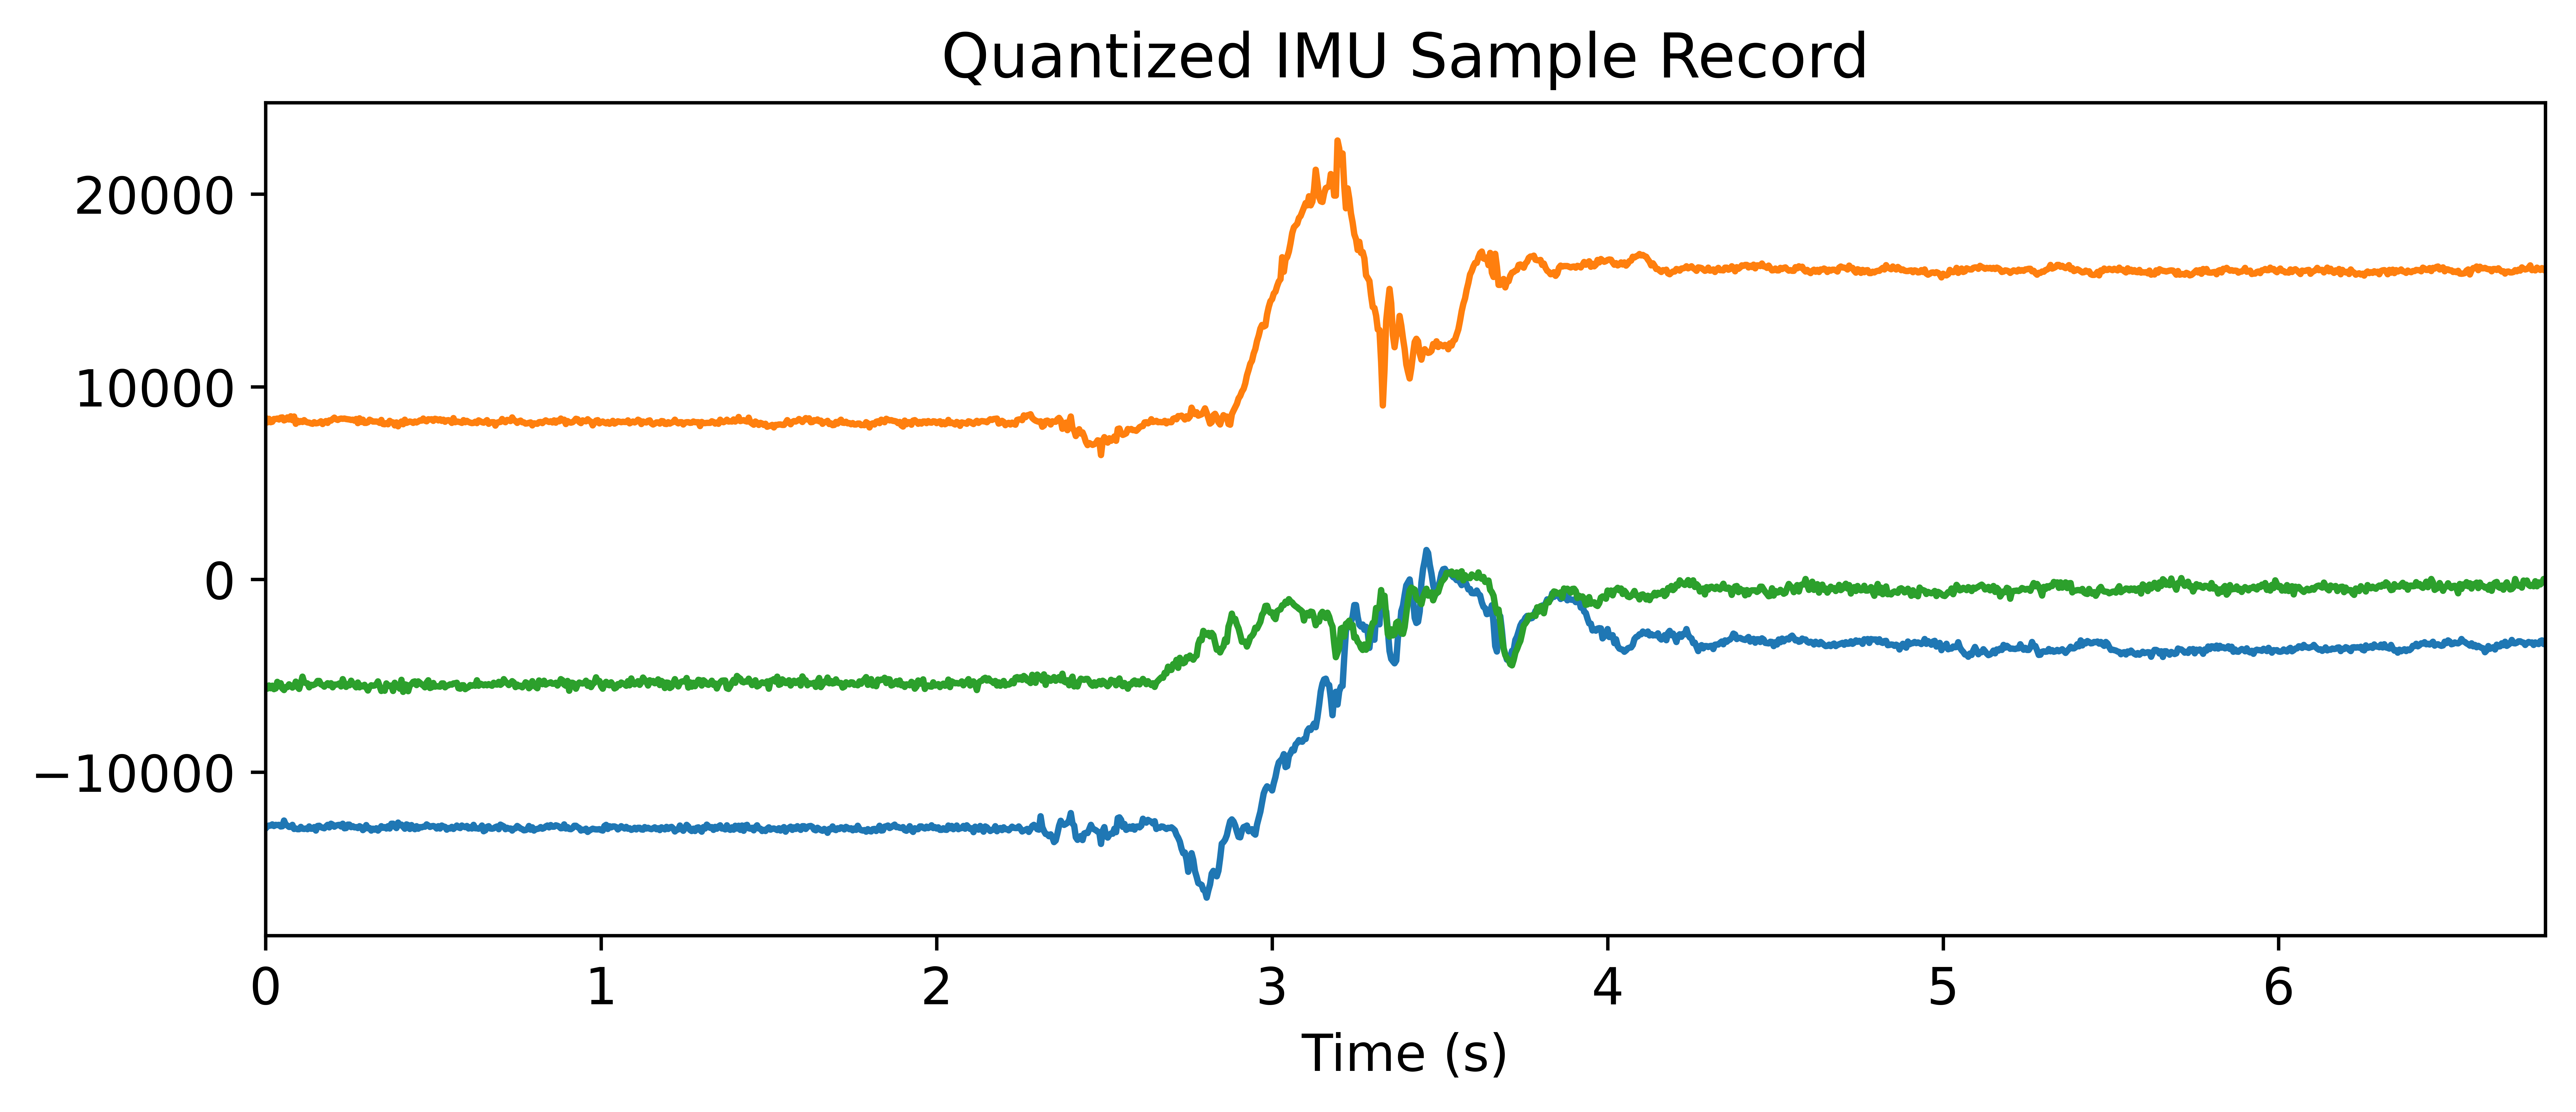

In [5]:
## Step 1 : Quantize the data
dt = 5e-3

with open("data.npy", "rb") as f:
    data = np.load(f)
    
quantizer = Quantizer(scale=0.49, num_bits=16)
data_quantized, _, _ = quantizer(data)
data_quantized.shape

plt.figure()
TSContinuous.from_clocked(data_quantized[0], dt=dt).plot()
plt.title(f"Quantized IMU Sample Record")
plt.show()


In [6]:
mod_IMUIF = IMUIFSim(select_iaf_output=True)


WARNING    /home/ugurcan/SynSense Dropbox/Ugurcan Cakal/repos/rockpool/rockpool/devices/xylo/imu/preprocessing/lookup.py:59: RuntimeWarning: divide by zero encountered in divide
  self.cot2_vals = 1 / np.tan(2 * self.angles_radian)
 [py.warnings]
  self.cot2_vals = 1 / np.tan(2 * self.angles_radian)



In [7]:
result, _, _ = mod_IMUIF(data_quantized)
result.shape

WARNING    /home/ugurcan/SynSense Dropbox/Ugurcan Cakal/repos/rockpool/rockpool/devices/xylo/imu/preprocessing/jsvd.py:79: UserWarning: The input covariance matrix does not seem to be PSD! This may cause numerical issues in computation!
  warnings.warn(
 [py.warnings]
  warnings.warn(

WARNING    /home/ugurcan/SynSense Dropbox/Ugurcan Cakal/repos/rockpool/rockpool/devices/xylo/imu/preprocessing/jsvd.py:248: UserWarning: negative diagonal elements encountered during covariance update!
  warnings.warn(
 [py.warnings]
  warnings.warn(



(1, 1360, 15)

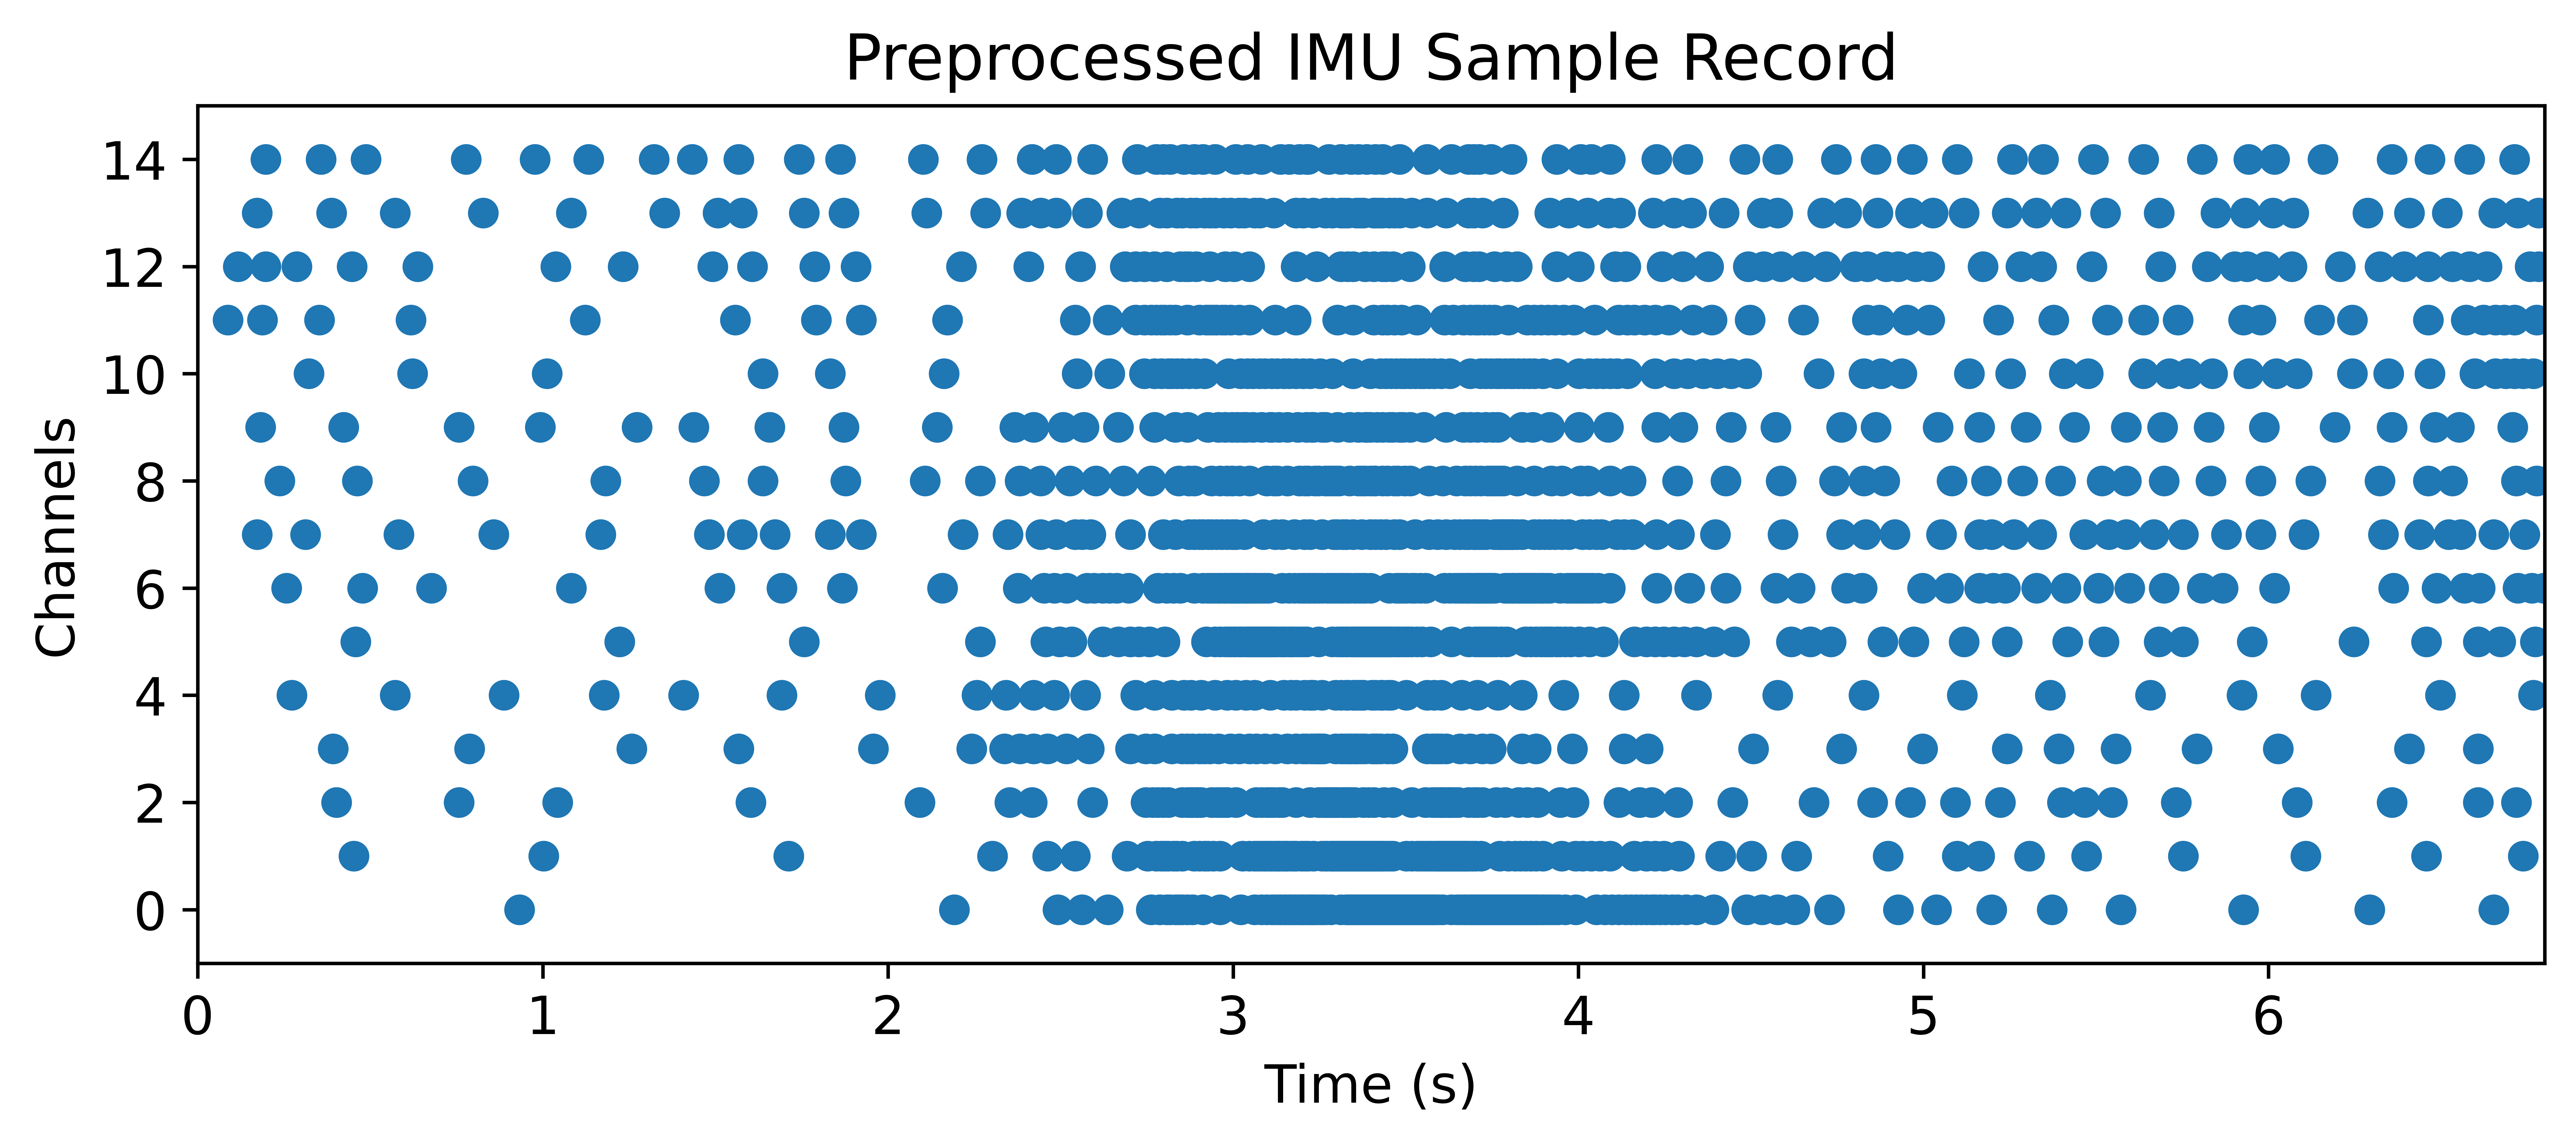

In [12]:
plt.figure()
TSEvent.from_raster(np.abs(result[0]), dt=dt).plot()
plt.title(f"Preprocessed IMU Sample Record")
plt.show()

In [9]:
config = mod_IMUIF.export_config()
print(config.to_json())

{
    "value0": {
        "enable": true,
        "configurationTimeout": 3.0,
        "estimatorKSetting": 4,
        "selectIafOutput": true,
        "bypassJSVD": false,
        "updateMatrixThreshold": 10,
        "delayThreshold": 500,
        "bpfBbValues": {
            "value0": 6,
            "value1": 5,
            "value2": 4,
            "value3": 3,
            "value4": 2,
            "value5": 6,
            "value6": 5,
            "value7": 4,
            "value8": 3,
            "value9": 2,
            "value10": 6,
            "value11": 5,
            "value12": 4,
            "value13": 3,
            "value14": 2
        },
        "bpfBwfValues": {
            "value0": 8,
            "value1": 8,
            "value2": 8,
            "value3": 8,
            "value4": 8,
            "value5": 8,
            "value6": 8,
            "value7": 8,
            "value8": 8,
            "value9": 8,
            "value10": 8,
            "value11": 8,
            "val

In [10]:
config = InputInterfaceConfig(enable=True)
print(config.to_json())

{
    "value0": {
        "enable": true,
        "configurationTimeout": 3.0,
        "estimatorKSetting": 5,
        "selectIafOutput": false,
        "bypassJSVD": false,
        "updateMatrixThreshold": 255,
        "delayThreshold": 500,
        "bpfBbValues": {
            "value0": 6,
            "value1": 6,
            "value2": 6,
            "value3": 6,
            "value4": 6,
            "value5": 6,
            "value6": 6,
            "value7": 6,
            "value8": 6,
            "value9": 6,
            "value10": 6,
            "value11": 6,
            "value12": 6,
            "value13": 6,
            "value14": 6
        },
        "bpfBwfValues": {
            "value0": 8,
            "value1": 8,
            "value2": 8,
            "value3": 8,
            "value4": 8,
            "value5": 8,
            "value6": 8,
            "value7": 8,
            "value8": 8,
            "value9": 8,
            "value10": 8,
            "value11": 8,
            "v

In [11]:
mod_IMUIF.from_config(config)

IMUIFSim  with shape (3, 15) {
    ModSequential 'model' with shape (3, 15) {
        RotationRemoval '0_RotationRemoval' with shape (3, 3) {
            ModSequential 'sub_estimate' with shape (3, 9) {
                SubSpace '0_SubSpace' with shape (3, 9)
                SampleAndHold '1_SampleAndHold' with shape (9, 9)
            }
        }
        FilterBank '1_FilterBank' with shape (3, 15)
        ScaleSpikeEncoder '2_ScaleSpikeEncoder' with shape (15, 15)
    }
}